![](../images/dtlogo.png)



# Object Detection

Machine-learned object detection models can be extremely useful. They are faster and often more reliable than traditional computer vision models. Additionally, we can use pretrained model weights to cut down immensely on training time.

Here's an example of what an object detector might output:



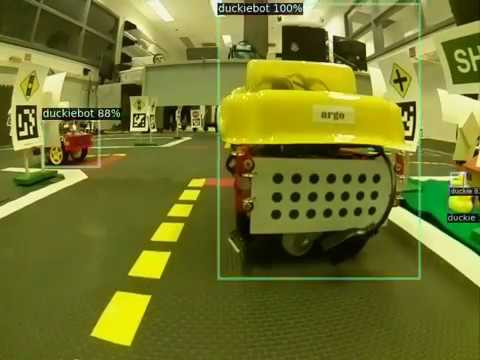

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('3jD02dxL6gg', width=800, height=500)


In this exercise, you will create your own Duckietown object detection dataset. You will learn about the general structure such a dataset should follow. You will train the object detection model on that dataset ([in a subsequent notebook](../03-Training/training.ipynb). Finally, you will integrate the model into a ROS node and test the integration ([in the last notebook](../04-Integration/integration.ipynb), so that your Duckiebot knows how to recognize duckie pedestrians (and thus avoid them). You can test your object detector in simulation and on your real Duckiebot.

### Steps:

1. Setup  
2. Investigation
3. Data collection
4. Training
5. Integration



### 1. Setup

First, we need some global variables. These allow you to change the directory where we save of of the data you will need. You can also change the image size to reflect what your final model uses, but you can worry about that later.

In [2]:
DATASET_DIR="/jupyter_ws/solution/duckietown_dataset"
IMAGE_SIZE = 416
# this is the percentage of data that will go into the training set (as opposed to the testing set)
SPLIT_PERCENTAGE = 0.8

While you will build your own dataset with simulated images in part 2, it would be unreasonable to ask you to build your own dataset of real images. Run the cell bellow to download a dataset of labelled real images.

In [3]:
from utils import runp

runp(f"rm -rf {DATASET_DIR}")
runp(f"mkdir {DATASET_DIR}")
runp(f"mkdir {DATASET_DIR}/images")
runp(f"mkdir {DATASET_DIR}/labels")
runp(f"mkdir {DATASET_DIR}/train")
runp(f"mkdir {DATASET_DIR}/val")
runp(f"mkdir {DATASET_DIR}/train/images")
runp(f"mkdir {DATASET_DIR}/train/labels")
runp(f"mkdir {DATASET_DIR}/val/images")
runp(f"mkdir {DATASET_DIR}/val/labels")

# use <!> to have a download indicator
!wget -O duckietown_object_detection_dataset.zip https://www.dropbox.com/s/bpd535fzmj1pz5w/duckietown%20object%20detection%20dataset-20201129T162330Z-001.zip?dl=0
runp(f"unzip -q duckietown_object_detection_dataset.zip -d {DATASET_DIR}")
runp(f"mv {DATASET_DIR}/duckietown\ object\ detection\ dataset/* {DATASET_DIR} && rm -rf {DATASET_DIR}/duckietown\ object\ detection\ dataset")
runp(f"rm duckietown_object_detection_dataset.zip")












--2021-07-22 01:20:58--  https://www.dropbox.com/s/bpd535fzmj1pz5w/duckietown%20object%20detection%20dataset-20201129T162330Z-001.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.11.18, 2620:100:6050:18::a27d:b12
Connecting to www.dropbox.com (www.dropbox.com)|162.125.11.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/bpd535fzmj1pz5w/duckietown%20object%20detection%20dataset-20201129T162330Z-001.zip [following]
--2021-07-22 01:20:59--  https://www.dropbox.com/s/raw/bpd535fzmj1pz5w/duckietown%20object%20detection%20dataset-20201129T162330Z-001.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc62a0ba92822c9713f00b2046ff.dl.dropboxusercontent.com/cd/0/inline/BSv735Q3nA5gPFP-M7-wCbmgywbDbu2L2g0AnW_OqKz6Zr0HJel_Brvlvv5npOdftndQJLxDOYY8dliREBy37V25lUNyqjllzZI4h2fXFSmQzcfJ8YqTmABRmVVn6mwtKwk6oTjLdo99v4V0NzHmWQiJ/file# [following]
--2021-07-2

These real images are not the right size. Run the cell bellow to resize them (and resize the associated bounding boxes accordingly).


In [4]:
import json
import os
import cv2
import numpy as np
from tqdm import tqdm
from utils import xminyminxmaxymax2xywfnormalized, train_test_split, makedirs, runp




with open(f"{DATASET_DIR}/annotation/final_anns.json") as anns:
    annotations = json.load(anns)

In [5]:
npz_index = 0

all_image_names = []
    
def save_img(img, boxes, classes):
    global npz_index
    cv2.imwrite(f"{DATASET_DIR}/images/real_{npz_index}.jpg", img)
    with open(f"{DATASET_DIR}/labels/real_{npz_index}.txt", "w") as f:
        for i in range(len(boxes)):
            f.write(f"{classes[i]} "+" ".join(map(str,boxes[i]))+"\n")
    npz_index += 1
    all_image_names.append(f"real_{npz_index}")

filenames = tqdm(os.listdir(f"{DATASET_DIR}/frames"))
for filename in filenames:
    img = cv2.imread(f"{DATASET_DIR}/frames/{filename}")

    orig_y, orig_x = img.shape[0], img.shape[1]
    scale_y, scale_x = IMAGE_SIZE/orig_y, IMAGE_SIZE/orig_x

    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))

    boxes = []
    classes = []

    if filename not in annotations:
        continue

    for detection in annotations[filename]:
        box = detection["bbox"]
        label = detection["cat_name"]

        if label not in ["duckie", "cone"]:
            continue

        orig_x_min, orig_y_min, orig_w, orig_h = box

        x_min = int(np.round(orig_x_min * scale_x))
        y_min = int(np.round(orig_y_min * scale_y))
        x_max = x_min + int(np.round(orig_w * scale_x))
        y_max = y_min + int(np.round(orig_h * scale_y))

        boxes.append([x_min, y_min, x_max, y_max])
        classes.append(1 if label == "duckie" else 2)

    if len(boxes) == 0:
        continue


    boxes = np.array([xminyminxmaxymax2xywfnormalized(box, IMAGE_SIZE) for box in boxes])
    classes = np.array(classes)-1
    
    save_img(img, boxes, classes)



train_test_split(all_image_names, SPLIT_PERCENTAGE, DATASET_DIR)

100%|██████████| 1963/1963 [00:14<00:00, 136.90it/s]


Once that's done, you're all set! We'll explain what all the code above was for later in this notebook.

### Investigation

What does an object detection dataset look like? Clearly, the specifics will depend on the convention used by specific models, but the general idea is intuitive:

- We need an image
- This image might have many bounding boxes in it, so we need some sort of list of coordinates
- These bounding boxes must be associated with a class

How are the bounding boxes defined?

![image of a bounding box](../images/bbox.png)

\[Note: if you are not colorblind, you may ignore the scribbles under the colored indications for widths and heights\]

Some conventions use `x_min y_min width height`, whereas others use `x_min y_min x_max y_max`, and others use `x_center y_center width height`. In this exercise, the model we recommend ([YoloV5](https://github.com/Velythyl/yolov5)) uses `x_center y_center width height`.

And how do we actually obtain these bounding boxes? In real-life applications, you would need to label a dataset of images by hand. But if you have access to a simulator that is able to segment images, you could obtain the bounding boxes directly from the segmented images. 

If you take a look at Pytorch's object detection [tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html), that is similar to what they do. While their images were segmented by hand, the tutorial uses the same technique that we will use here to obtain the bounding boxes. Their images look like this:

![image with bounding boxes](../images/FudanPed.png)
<p align="center">\[Source: https://www.cis.upenn.edu/~jshi/ped\_html/\]</p>

And they simply calculate the min and max x and y coordinates of the segmented objects to obtain the bounding box.

We will use the segmented mode in the Duckietown simulator to compute the bounding boxes of non-segmented images.

#### What we want to detect

The goal of this exercise is to make Duckietown safer: we want to be able to detect duckie pedestrians on the road and avoid squishing them. We also want to detect trucks, buses, and cones. Here is the complete list, along with their corresponding IDs:

0. Duckie
1. Cone
2. Truck
3. Bus


## Data collection


#### Format

We are going to supplement the data from the real dataset that we already downloaded with data automatically generated from the simulator. 

The script we will use for this is the [../utils/data_collection.py](../utils/data_collection.py) file. You can edit it manually but the functions that are defined later in this notebook are automatically used by the script so unless you are interested to see all of the details, you can just continue with this notebook. 

You can run the script in the noVNC browser. **NB: if this doesn't work you should rerun `dts exercises lab` with the `--vnc` flag**. 

Navigate to [http://localhost:8087](http://localhost:8087) and click the "Data Collection" icon on the desktop. This will run your [../utils/data_collection.py](../utils/data_collection.py) script. If you edit the functions below, you simply need to rerun `dts exercises build` and then re-click on the data collection. The functions are pulled from this notebook and imported into the [../utils/data_collection.py](../utils/data_collection.py) script. 

The purpose of that [../utils/data_collection.py](../utils/data_collection.py) is to automatically generate data for you from the simulator. In the rest of this activity we will walk step by step through the process. 

Of course, your dataset's format depends heavily on your model. If you want to use the [YoloV5](https://github.com/duckietown/yolov5) model that we suggest, you should colosely follow their [guide on how to train using custom data](https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data).

Your data should follow the following directory structure:

![image of dataset save format](../images/dataset_format.png)

The dataset is called `duckietown_dataset` and is located in the parent directory of this notebook. We have created two subdirectories in that folder: `train` and `val`. Inside `train` and `val`, there must again be two subdirectories `images` and `labels`. Inside `images`, you must place your images, and inside `labels`, you must place the images' bounding box data. Notice that the label files use the same name as their corresponding image files but with a different extension. In other words, the data for `0.jpg` can be found in `0.txt`.

The format for the label files is fairly simple. For each bounding box in the corresponding image, write a row of the form `class x_center y_center width height`. Keep in mind that the pixel data must be 0-to-1 normalized (i.e., you can calculate the usual `x_center y_center width height` in pixel space and divide by the image's size). For example,

    0 0.5 0.5 0.2 0.2
    1 0.60 0.70 0.4 0.2

this says "there is a duckie (class 0) centered in the image, whose width and height are 20% of the image's. There is also a cone (class 1) whose center is at 60% of the image's maximal x value and 70% of the image's maximal y value, and its width is 40% of the image's own while its height is 20%."

It is recommended that you read the guide posted on YoloV5's GitHub: [guide on how to train using custom data](https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data).

#### Generating data

1. Take the segmented image (this is provided to you by the simulator's rendering engine)



In [ ]:
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
mapping = {
    "house": "3deb34",
    "bus": "ebd334",
    "truck": "961fad",
    "duckie": "cfa923",
    "cone": "ffa600",
    "floor": "000000",
    "grass": "000000",
    "barrier": "000099"
}
mapping = {
    key:
        [int(h[i:i+2], 16) for i in (0,2,4)]
    for key, h in mapping.items()
}

In [ ]:
# Feel free to experiment with a few other files in the images folder. All of the original/segmented pairs are labeled as *_not_seg and *_seg
obs = np.asarray(Image.open('../images/duckie_not_seg.png'))
obs_seg = np.asarray(Image.open('../images/duckie_seg.png'))
# define the mapping from objects to colours


In [ ]:
plt.imshow(obs)

In [ ]:
plt.imshow(obs_seg)

2. For each color in the interesting colors (so the colors for duckies, trucks, busses, and cones):
   
   1. Remove all other colors


In [ ]:
def segmented_image_one_class(segmented_img, class_name):
    mask = np.all(segmented_img == mapping[class_name], axis=-1)
    return mask

In [ ]:
duckie_masked_image = segmented_image_one_class(np.asarray(obs_seg),"duckie")
plt.imshow(duckie_masked_image)

    B. Then take that image and use it to find bounding boxes around each unique instance within the image

In [ ]:
def find_all_bboxes(mask):
    gray = mask.astype("uint8")
    gray[mask == True] = 255
    gray[mask == False] = 0

    contours, hierarchy = cv2.findContours(gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[-2:]

    boxes = []
    for index, cnt in enumerate(contours):
        if hierarchy[0,index,3] != -1:
            continue

        x, y, w, h = cv2.boundingRect(cnt)
        boxes.append([x,y,w+x,h+y])

    boxes = np.array(boxes)

    return boxes

In [ ]:
def show_image_with_boxes(img, boxes):
    import matplotlib.patches as patches
    fig, ax = plt.subplots()
    ax.imshow(img)
    for box in boxes:
        rect = patches.Rectangle((box[0], box[2]), box[1]-box[0], box[3]-box[2], linewidth=1, edgecolor='w', facecolor='none')
        ax.add_patch(rect)
    plt.show()
    

In [ ]:
boxes = find_all_bboxes(duckie_masked_image)
show_image_with_boxes(obs,boxes)


    C. Now we want a function that does the above but for all classes

In [ ]:
def find_all_boxes_and_classes(segmented_img):

    classes = ["duckie", "cone", "truck", "bus"]
    all_boxes = []
    all_classes = []

    for i, class_name in enumerate(classes):
        mask = segmented_image_one_class(segmented_img, class_name)
        boxes = find_all_bboxes(mask)
        all_boxes.extend(list(boxes))
        classes = np.array([i]*boxes.shape[0])
        all_classes.extend(list(classes))

    return all_boxes, all_classes


In [ ]:
all_boxes, all_classes = find_all_boxes_and_classes(obs_seg)
show_image_with_boxes(obs, all_boxes)


Finally we will need to save the non-segmented version of the image, and write its bounding boxes + their classes to a corresponding txt file. You can see how this is done in [../utils/data_collection.py](../utils/data_collection.py)


#### Combining with the real dataset & training/test set splits

When training supervised learning models, one must worry about overfitting to your training set. You should always keep *some* of your dataset *out* of your training data. This way, you can verify that your model does not overfit to your dataset by *testing* it on the data you left out. 

You can experiment with the `SPLIT_PERCENTAGE` variable defined at the top of this notebook to adjust the percentage of the **real** data that is used for training as opposed to testing. There is a similar variable defined in [../utils/data_collection.py](../data_collection.py) which controls the percentage of the **simulated** data that will be used for training. 

## Finishing up

Make sure if you modified these functions or the code in [../utils/data_collection.py](../data_collection.py) that you **rerun `dts exercises build`** and go back to the [novnc browser](http://localhost:8087) and re-run the data generation procedure. 


# Next step

You can continue with the [Training notebook](../03-Training/training.ipynb)